### Importing libraries and settings

### Index:
* Feature creation (tools.py)
* Adding clasic readability tests to the mix
* First Model
    * Dale-Chall test
    * Smog Index test
    * Correlation Plot
    * Pairplot for feature selection
    * Model selection
    * First model metrics

In [1]:
# project tools:
from tools import *

# built-in libraries:
import math
from collections import defaultdict

# data wrangling libraries:
import numpy as np
import pandas as pd

# Ploting libraries:
import matplotlib.pyplot as plt
import seaborn as sns

# text manipulation libraries:
import textstat
import nltk
from nltk.corpus import stopwords

# xgboost model library:
from xgboost import XGBRegressor

# sklearn pre-train methods:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# sklearn models:
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# sklearn pipelines and metrics:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

/home/jose/Desktop/Udacity_Project/tools.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


##### First check out the tools.py code to understand the functions I'm going to use bellow.

In [2]:
def add_creative_features(dataframe):
    """
    This function applies the tools.py functions I wrote into every excerpt.
    """
    dataframe['num_punct_marks'] = dataframe['excerpt'].apply(num_punct_marks)
    dataframe['num_uniq_words'] = dataframe['excerpt'].apply(num_unique_words)
    dataframe['avg_word_len'] = dataframe['excerpt'].apply(avg_word_len)
    dataframe['rarity'] = dataframe['excerpt'].apply(rarity)


def add_clasic_test(dataframe):
    """
    This function applies all the publicly available readability test into every excerpt.
    """
    clasical_complexity_tests = {'fre_test': textstat.flesch_reading_ease,
                                 'fkg_test': textstat.flesch_kincaid_grade,
                                 'gf_test': textstat.gunning_fog,
                                 'si_test': textstat.smog_index,
                                 'dcrs_test': textstat.dale_chall_readability_score}

    # Creating text complexity feature for every test:
    for test in clasical_complexity_tests.keys():
        test_func = clasical_complexity_tests[test]

        dataframe[test] = dataframe['excerpt'].apply(lambda value: test_func(value))

### Creating clasic text complexity features to the train dataset:

In [3]:
# let's import only the columns that matter
train = pd.read_csv('train.csv', usecols=['id', 'excerpt', 'target'])

In [4]:
add_creative_features(train)
add_clasic_test(train)

## First Model

#### The main idea is to improve the Benchmark score by using not only the FRE test but a combination of diferent reading tests + a couple of custom indicators I wanted to try!

In [5]:
train.describe()

,target,num_punct_marks,num_uniq_words,avg_word_len,rarity,fre_test,fkg_test,gf_test,si_test,dcrs_test
count,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000
mean,-0.966915,23.441961,106.073725,4.490131,11.164532,67.713859,9.651216,11.758388,10.327843,6.722729
std,1.031885,6.307005,13.069152,0.433239,0.505391,17.674557,4.494785,4.606696,3.310826,1.935937
min,-3.676268,8.000000,37.000000,3.142105,9.266312,-22.930000,-0.900000,2.040000,0.000000,0.400000
25%,-1.696522,19.000000,97.000000,4.186384,10.868384,57.300000,6.800000,8.820000,8.100000,6.100000
50%,-0.925342,23.000000,106.000000,4.452053,11.252890,68.955000,9.300000,11.220000,10.300000,6.970000
75%,-0.214269,27.000000,115.000000,4.743195,11.529050,80.140000,11.800000,13.950000,12.500000,7.837500
max,1.711390,63.000000,142.000000,6.883871,12.327100,114.520000,39.700000,44.300000,22.900000,12.580000


#### The features were created successfully.

In [6]:
train_corrs = train.corr()
train_corrs

,target,num_punct_marks,num_uniq_words,avg_word_len,rarity,fre_test,fkg_test,gf_test,si_test,dcrs_test
target,1.000000,0.093544,-0.220559,-0.423565,0.461530,0.523288,-0.445349,-0.449362,-0.530162,-0.551317
num_punct_marks,0.093544,1.000000,0.231920,-0.126228,0.096607,0.259905,-0.265684,-0.264399,-0.238775,-0.245459
num_uniq_words,-0.220559,0.231920,1.000000,0.098333,0.142660,-0.096532,0.127858,0.152072,0.095055,0.215334
avg_word_len,-0.423565,-0.126228,0.098333,1.000000,-0.582029,-0.733533,0.413601,0.342241,0.740996,0.727327
rarity,0.461530,0.096607,0.142660,-0.582029,1.000000,0.511351,-0.321600,-0.294419,-0.517506,-0.504415
fre_test,0.523288,0.259905,-0.096532,-0.733533,0.511351,1.000000,-0.894137,-0.840728,-0.758457,-0.787740
fkg_test,-0.445349,-0.265684,0.127858,0.413601,-0.321600,-0.894137,1.000000,0.983320,0.531154,0.638907
gf_test,-0.449362,-0.264399,0.152072,0.342241,-0.294419,-0.840728,0.983320,1.000000,0.503159,0.608908
si_test,-0.530162,-0.238775,0.095055,0.740996,-0.517506,-0.758457,0.531154,0.503159,1.000000,0.708080
dcrs_test,-0.551317,-0.245459,0.215334,0.727327,-0.504415,-0.787740,0.638907,0.608908,0.708080,1.000000


#### From the custom indicators I created the most correlated to the target one is the *rarity index* and the *average word longitude*.

#### If we check the clasic redability tests we can spot that the correlation top is:
* DCRS_test
* SI_test
* FRE_test (used in the bechmark)

### Dale-Chall test summary

The Dale–Chall readability formula is a readability test that provides a numeric gauge of the comprehension difficulty that readers come upon when reading a text. It uses a list of 3000 words that groups of fourth-grade American students could reliably understand, considering any word not on that list to be difficult. 

Formula:
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/0541f1e629f0c06796c5a5babb3fac8d100a858c'>


##### Source: https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula

### Smog Index test summary

The SMOG grade is a measure of readability that estimates the years of education needed to understand a piece of writing. This test is known for using the number of polysyllables to estimate the complexity of the text.

Formula:
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/da193073ce4254e54b077fbf56e418b14b50b9cd'>

##### Source: https://en.wikipedia.org/wiki/SMOG

### Correlation plot

#### Let's see the correlation matrix again in a more visual matter to spot any co-linearity

<AxesSubplot:>

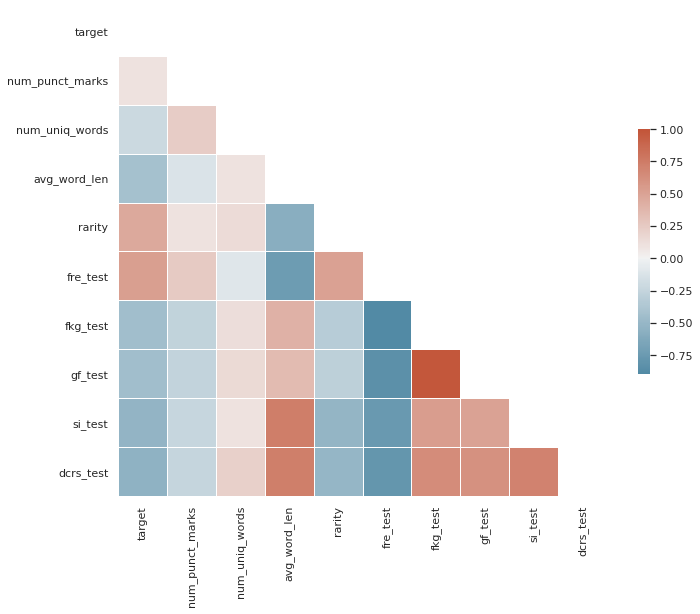

In [7]:
# setting plot style
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(train_corrs, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(train_corrs, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### We need to be aware of the fact that some of the test are highly correlated between them. 
* The bigest correlation are GF_test and the FKG_test, that is ok since we are not going to use any of those.
* Also the FKG test and FRE test have high correlation, we are going to use only the FRE test.
* the rarity measure is not barely correlated with the rest so let's use it as well.
* The DCRS test have an inverse correlation with the Smog index. Let's use only one.

#### Let's inspect the scatterplots of our candidate variables for the model:

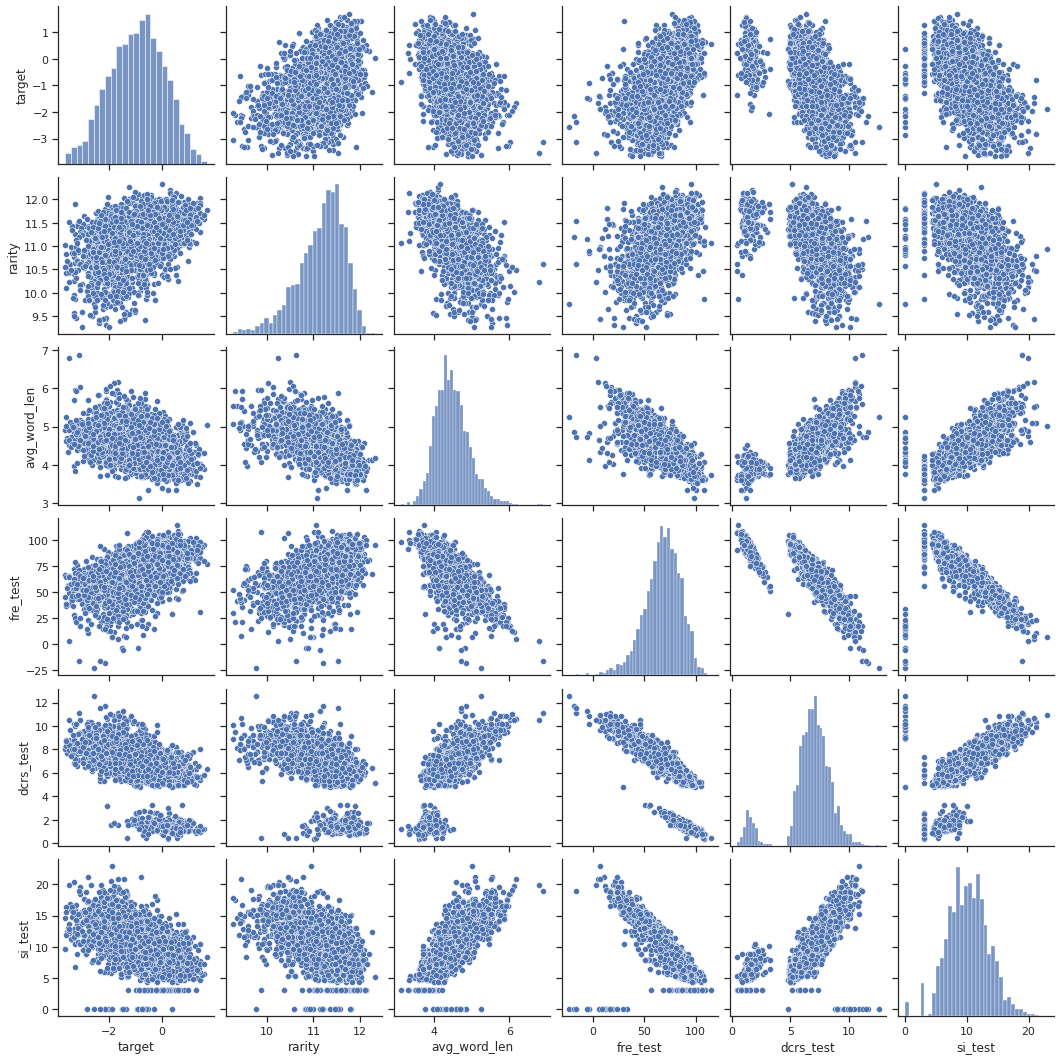

In [8]:
sns.set_theme(style="ticks")
sns.pairplot(train[['target', 'rarity', 'avg_word_len','fre_test', 'dcrs_test', 'si_test']])

##### The Smog index generated some weird plots, so let's discard it and use only the DCRS test.

### Training a model

#### The features we are going to use are:
* rarity
* average word longitude
* FRE test
* DCRS test

#### Also considered we are going to check the results on the validation set, tune the best model, pick it and only them make just one try with the test set.

#### Again this was the first model I tried out, bear in mind that the most robust answer is in the final model

In [9]:
# train vectors
X_train = train['excerpt']
y_train = train['target']

# validation vectors
# This validation set will be useful to select the best model.
validation = pd.read_csv('validation.csv', usecols=['id', 'excerpt', 'target'])
add_creative_features(validation)
add_clasic_test(validation)

X_validation = validation['excerpt']
Y_validation = validation['target']

### Models to try:

In [10]:
models = {'Elastic Net': ElasticNet(),
          'Lasso': Lasso(),
          'MLPRegressor': MLPRegressor(),
          'Ridge': Ridge(),
          'LinearSVR': LinearSVR(),
          'RandomForest': RandomForestRegressor(),
          'XGBoost': XGBRegressor(n_estimators=1000, eta=0.1, tree_method='hist'), 
          'SVR': SVR(kernel = 'rbf')}

In [11]:
models.items()

dict_items([('Elastic Net', ElasticNet()), ('Lasso', Lasso()), ('MLPRegressor', MLPRegressor()), ('Ridge', Ridge()), ('LinearSVR', LinearSVR()), ('RandomForest', RandomForestRegressor()), ('XGBoost', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, eta=0.1, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method='hist',
             validate_parameters=None, verbosity=None)), ('SVR', SVR())])

In [12]:
variables = ['rarity', 'avg_word_len', 'fre_test', 'dcrs_test']

# Let's iterate over every candidate model, train it and compare results
for model, regressor in models.items():
    # training:
    X_train = train[variables].values
    
    # fitting model
    regressor.fit(X_train, y_train)
    
    # checking the model results in the validation set
    X_test = validation[variables].values
    X_test_pred = regressor.predict(X_test)
    
    # metrics
    r2 = round(regressor.score(X_test, Y_validation), 3)
    mae = round(mean_absolute_error(Y_validation, X_test_pred), 3)
    rmse = round(math.sqrt(mean_squared_error(Y_validation, X_test_pred)), 3)
    
    # Printing results
    print(f'{model} vs target... R2: {r2}')
    print(f'{model}  vs target... MAE: {mae}')
    print(f'{model}  vs target... RMSE: {rmse}', '\n')

Elastic Net vs target... R2: 0.254
Elastic Net  vs target... MAE: 0.716
Elastic Net  vs target... RMSE: 0.879 

Lasso vs target... R2: 0.25
Lasso  vs target... MAE: 0.719
Lasso  vs target... RMSE: 0.881 

MLPRegressor vs target... R2: 0.374
MLPRegressor  vs target... MAE: 0.631
MLPRegressor  vs target... RMSE: 0.805 

Ridge vs target... R2: 0.4
Ridge  vs target... MAE: 0.626
Ridge  vs target... RMSE: 0.788 

LinearSVR vs target... R2: -0.815
LinearSVR  vs target... MAE: 1.162
LinearSVR  vs target... RMSE: 1.371 



/home/jose/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


RandomForest vs target... R2: 0.312
RandomForest  vs target... MAE: 0.651
RandomForest  vs target... RMSE: 0.844 

XGBoost vs target... R2: 0.209
XGBoost  vs target... MAE: 0.708
XGBoost  vs target... RMSE: 0.905 

SVR vs target... R2: 0.354
SVR  vs target... MAE: 0.649
SVR  vs target... RMSE: 0.818 



#### As you can see, without tweaking to much the models we can see better results than the bechmark just having selected nice features 

#### Top models in the validation set:
* Multi-Layer Perceptron regressor (19% better than bechmark)
* Support Vector Regressor (16% better than bechmark)
* Ridge Regression (16% better than bechmark)

#### of course this comparison is between the validation set and the test set, the final comparison will be with the test set vs test set.

## The final model will be on an independent jupyter notebook to make everything neat and clean